# Functions

In [1]:

import pandas as pd


def analyse_dataframe(dataframe):
    label_columns = [col for col in dataframe.columns if col.startswith('label_')]
    analysis_columns = [col for col in dataframe.columns if col.startswith('analysis_')]
    categories = [col.replace('label_', '') for col in label_columns]
    text_column = 'text'

    print(f"Categories: {categories}")
    print(f"Labels: {label_columns}")
    print(f"Analysis: {analysis_columns}")
    print(f"Input: {text_column}")

    #non_neutral = dataframe[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    #neutral = dataframe[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    non_neutral = len(dataframe[dataframe['label_neutral'] == False])
    neutral = len(dataframe[dataframe['label_neutral'] == True])

    print(f'\nRows: {len(dataframe)}')
    print(f'Has at least one bias category: {non_neutral} ({non_neutral / len(dataframe):.2%})')
    print(f'Has no bias categories: {neutral} ({neutral / len(dataframe):.2%})')



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_by_category(dataframe, x_ideal=-1):
    label_columns = [col for col in dataframe.columns if col.startswith('label_')]
    melted_df = dataframe.melt(id_vars='synthetic', value_vars=label_columns, var_name='categories')
    melted_df = melted_df[melted_df['value'] == 1]
    
    
    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    
    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    total_real_str = '{:,.0f}'.format(non_neutral_real + neutral_real)
    total_synthetic_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic)
    
    pivot_df = melted_df.pivot_table(index='categories', columns='synthetic', aggfunc='size', fill_value=0)
    pivot_df.index = pivot_df.index.str.replace('label_', '')
    pivot_df = pivot_df.sort_values(by=False, ascending=True)
    pivot_df = pivot_df.rename(columns={True: 'Synthetic', False: 'Real'})
    
    plt.figure(figsize=(20, 20))
    bar_plot = pivot_df.plot(kind='barh', stacked=True, color=['#6495ED', '#FFA500'])
    
    plt.title('Verified Biased Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    
    plt.legend([f'{total_real_str} Real', f'{total_synthetic_str} Synthetic'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='')
    
    # Add values onto the chart
    #for rect in bar_plot.patches:
    #    width = rect.get_width()
    #    if width > 0:
    #        y = rect.get_y() + rect.get_height() / 2
    #        x = rect.get_x() + width / 2
    #        bar_plot.text(x, y, str(int(width)), va='center', fontsize=16) 
    
    for rect in bar_plot.patches:
        width, height = rect.get_width(), rect.get_height()
        x, y = rect.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:.0f}'.format(width),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    
    
    # Set x limit 25% more than max value
    plt.xlim(0, pivot_df.values.max() * 1.25)
    
    
    if x_ideal > 0:
        # Draw a vertical line at x = 200
        plt.axvline(x=x_ideal, color="red", linestyle='--')
    
    plt.show()


def plot_neutral_vs_bias(dataframe):
    label_columns = [col for col in dataframe.columns if col.startswith('label_')]
    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    
    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
    
    #print(f'non neutral synthetic: {non_neutral_synthetic}')
    #print(f'non neutral real: {non_neutral_real}')
    #print(f'neutral synthetic: {neutral_synthetic}')
    #print(f'neutral real: {neutral_real}')
    
    total_real_str = '{:,.0f}'.format(non_neutral_real + neutral_real)
    total_synthetic_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic)
    neutral_str = '{:,.0f} Neutral'.format(neutral_synthetic + neutral_real)
    bias_cont_str = '{:,.0f} Bias'.format(non_neutral_synthetic + non_neutral_real)
    total_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic + neutral_real + non_neutral_real)
    
    data = {'Category': [bias_cont_str, bias_cont_str, neutral_str, neutral_str],
            'Count': [non_neutral_synthetic, non_neutral_real, neutral_synthetic, neutral_real],
            'synthetic': ['Synthetic', 'Real', 'Synthetic', 'Real']}
    synth_df = pd.DataFrame(data)
    
    
    plt.figure(figsize=(20, 10))
    
    bar_plot = synth_df['Count'].groupby([synth_df['Category'], synth_df['synthetic']]).sum().unstack().plot.barh(
        stacked=True, color=['#6495ED', '#FFA500'])
    
    plt.title(f'{total_str} Verified Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.legend([f'{total_real_str} Real', f'{total_synthetic_str} Synthetic'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='')
    
    patches = bar_plot.patches
    values = [non_neutral_real,neutral_real,non_neutral_synthetic,neutral_synthetic]
    
    # Display values for each segment
    for patch, value in zip(patches, values):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(value),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    
    plt.show()


def plot_by_models(dataframe):
    dataframe = dataframe[dataframe['synthetic'] == True]

    models = {}
    
    for meta in dataframe['metadata']:
        meta = json.loads(meta)
        model_name = meta['model']
        model_name = model_name.split(':')[-1]
        if model_name not in models:
            models[model_name] = 1
        else:
            models[model_name] += 1


    dataframe = pd.DataFrame(list(models.items()), columns=['Model', 'Count'])
    
    #model_names = dataframe['Model']
    model_counts = dataframe['Count']
    
    plt.figure(figsize=(10, 5))
    
    bar_plot = dataframe['Count'].groupby(dataframe['Model']).sum().plot.barh(color='#6495ED')
    
    plt.title('Verified Synthetic Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    
    patches = bar_plot.patches
    
    # Display values for each segment
    for patch, count in zip(patches, model_counts):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(count),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    plt.show()

# Training Data

In [3]:
df_train_verified = pd.read_parquet('../verified/rebalanced/output/verified-train.parquet')
df_val_verified = pd.read_parquet('../verified/rebalanced/output/verified-val.parquet')
df_test_verified = pd.read_parquet('../verified/rebalanced/output/verified-test.parquet')

df_train_unverified = pd.read_parquet('../unverified/output/unverified-train-mixed-polarity-synthetic.parquet')

print(f'df_train_verified.shape: {df_train_verified.shape}')
print(f'df_val_verified.shape: {df_val_verified.shape}')
print(f'df_test_verified.shape: {df_test_verified.shape}')
print(f'df_train_unverified.shape: {df_train_unverified.shape}')


df_train_verified.shape: (1439, 21)
df_val_verified.shape: (593, 21)
df_test_verified.shape: (584, 21)
df_train_unverified.shape: (2190, 19)


In [4]:

    
analyse_dataframe(df_val_verified)


Categories: ['age', 'disability', 'feminine', 'general', 'masculine', 'neutral', 'racial', 'sexuality']
Labels: ['label_age', 'label_disability', 'label_feminine', 'label_general', 'label_masculine', 'label_neutral', 'label_racial', 'label_sexuality']
Analysis: ['analysis_age', 'analysis_disability', 'analysis_feminine', 'analysis_general', 'analysis_masculine', 'analysis_neutral', 'analysis_racial', 'analysis_sexuality']
Input: text

Rows: 593
Has at least one bias category: 513 (86.51%)
Has no bias categories: 80 (13.49%)


In [5]:
label_columns = [col for col in df_test_verified.columns if col.startswith('label_')]
analysis_columns = [col for col in df_test_verified.columns if col.startswith('analysis_')]
categories = [col.replace('label_', '') for col in label_columns]
categories

['age',
 'disability',
 'feminine',
 'general',
 'masculine',
 'neutral',
 'racial',
 'sexuality']

In [6]:
label_columns_unverified = [col for col in df_train_unverified.columns if col.startswith('label_')]
df_train_unverified['label_neutral'] = df_train_unverified[label_columns_unverified].apply(lambda x: all([not i for i in x]), axis=1)
df_train_unverified['analysis_neutral'] = None

In [20]:
df_train = df_train_verified.copy()
df_train = df_train.sample(frac=1, random_state=2024)

# target = 480
target = len(df_test_verified[df_test_verified['label_neutral'] == True]) * 8 # Test verified are balanced so any column. Should be 80
for label in label_columns:
    verified = len(df_train_verified[df_train_verified[label] == True])
    unverified_df = df_train_unverified[df_train_unverified[label] == True]
    #unverified = len(unverified_df)
    needed = target - verified
    df_train = pd.concat([df_train, unverified_df.iloc[:needed:,:]])
    
df_train

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_neutral,analysis_neutral,label_racial,analysis_racial,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata
810,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,None,False,,False,The sexuality rationale in this job posting is...,True,True,"Company: Barker, Pierce and Banks\nJob Title: ...","{""position"": ""standards specialist"", ""inferenc..."
1062,Kaggle::techmap::614a798e287b955e077cff75::mon...,False,None,False,None,False,None,False,None,False,...,True,None,False,None,False,None,True,False,5-7 years of relevant work experience. \nExce...,"{""document_id"": ""Kaggle::techmap::614a798e287b..."
2567,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,None,False,,False,,True,True,"Data and Technology Analyst at Hall, Johnson a...","{""position"": ""data and technology analyst"", ""i..."
53,Kaggle::techmap::614d3714463aa27e3dae34a9::see...,False,None,False,None,False,None,False,None,False,...,True,None,False,None,False,None,True,False,Experienced Heavy Rigid Drivers\n\nABOUT THE C...,"{""document_id"": ""Kaggle::techmap::614d3714463a..."
1639,Kaggle::techmap::615a79907b7b7c7cc61ec029::see...,False,None,True,"The requirement for candidates to be ""physical...",False,None,False,None,True,...,False,None,False,None,False,None,True,False,3 MONTH CONTRACT. IMMEDIATE START. RESIDENTIAL...,"{""document_id"": ""Kaggle::techmap::615a79907b7b..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175,Synthetic:gpt-4o-2024-05-13:20240702134918:mix...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,We strive to build a workforce that reflects t...,False,True,<h1>About Us</h1>\n<p>Rainbow Tech is a forwar...,"{""position"": ""<GPT Will Generate>"", ""inference..."
2179,Synthetic:gpt-4o-2024-05-13:20240702134958:mix...,False,None,False,None,False,None,False,None,False,...,False,None,False,None,True,RainbowTech is particularly encouraging LGBTQ+...,False,True,Company Background:\n\nRainbowTech is a leadin...,"{""position"": ""<GPT Will Generate>"", ""inference..."
2183,Synthetic:gpt-4o-2024-05-13:20240702135037:mix...,False,None,True,We are committed to a diverse workplace and ac...,False,None,False,None,False,...,False,None,True,We are seeking to hire more individuals of Sou...,True,Our organization celebrates LGBTQ+ identities ...,False,True,<country>United States</country>\n <company>A...,"{""position"": ""flight engineer"", ""inference_tim..."
2188,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,None,False,None,True,The job posting encourages applications from w...,False,None,False,...,False,None,True,The job posting gives preference to candidates...,True,The job posting's emphasis on creating a safe ...,False,True,Country: New Zealand\nCompany: Pacific Horizon...,"{""position"": ""strategic initiatives coordinato..."


# Validation

<Figure size 1440x1440 with 0 Axes>

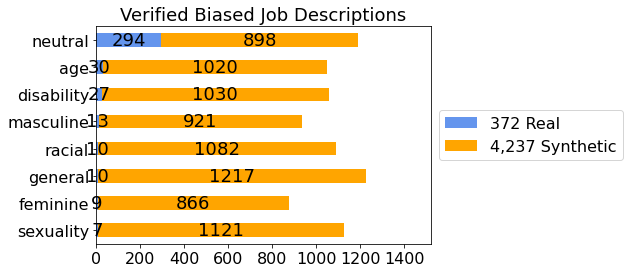

In [22]:
plot_by_category(df_train)

<Figure size 1440x1440 with 0 Axes>

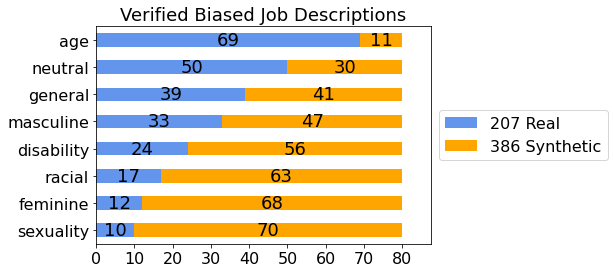

In [23]:
plot_by_category(df_val_verified)

<Figure size 1440x1440 with 0 Axes>

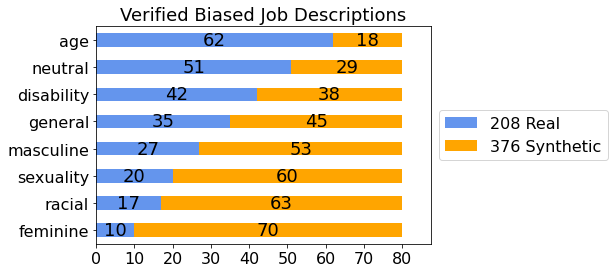

In [24]:
plot_by_category(df_test_verified)

In [25]:
df_train.to_parquet('final-train.parquet')
df_val_verified.to_parquet('final-val.parquet')
df_test_verified.to_parquet('final-test.parquet')